## Introduction
### Given materials

___
1. [**"Genomic and Transcriptomic Features of Response to Anti-PD-1 Therapy in Metastatic Melanoma"**](https://www.sciencedirect.com/science/article/pii/S009286741630215X), *Hugo et al.* [GSE78220](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE78220)  

>*This paper aims to search for genomic and transcriptomic predictors of the response/non-responce to Melanoma treatment using PD-1 immune checkpoint blockade, which has performed significant clinical benefit in oncology. However, this approach is limited in use by a high rate of inner resistence to anti-PD-1 therapy regardless of the rate of overall mutation load across the genome, thus non-genomic (transcriptomic) features has been searched.*
___

2. [**"Interferon Receptor Signaling Pathways Regulating PD-L1 and PD-L2 Expression"**](https://www.sciencedirect.com/science/article/pii/S2211124717305259), *Garcia-Diaz et al.* [GSE96619](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96619)

>*This research reveals mechanisms and regulations of PD-L1 and PD-L2 expression, which leads tumors to immune evasion, and thus is so important for immunotherapy based on PD-1 blockade. Analysis of biopsy specimens from patients with melanoma confirmed interferon signature enrichment and upregulation of gene targets in anti-PD-1-responding tumors. Therefore, these studies map the signaling pathway of interferon-gamma-inducible PD-1 ligand expression, that gives a new perspective on the way how to treat melanoma tumors.*

___


___
## 0. Data Pre-processing
___

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

### Load data from Excel files

In [3]:
train = pd.read_excel("Hugo/GSE78220_PatientFPKM.xlsx", "Sheet1")
test = pd.read_excel("Garcia/GSE96619_PatientFPKM.xlsx", "Sheet1")

### Take a look at the data arrangement

In [4]:
display(train.head())
print(train.shape)
display(test.head())
print(test.shape)

,Gene,Pt1.baseline,Pt2.baseline,Pt4.baseline,Pt5.baseline,Pt6.baseline,Pt7.baseline,Pt8.baseline,Pt9.baseline,Pt10.baseline,...,Pt25.baseline,Pt27A.baseline,Pt27B.baseline,Pt28.baseline,Pt29.baseline,Pt31.baseline,Pt32.baseline,Pt35.baseline,Pt37.baseline,Pt38.baseline
0,A1BG,8.025380,317.594000,5.747295,6.859570,1.563465,21.565850,11.370550,8.156810,4.346750,...,40.408950,6.093810,7.191755,8.595985,5.460340,14.788600,17.377200,11.644200,15.000300,4.475170
1,A1BG-AS1,0.677503,28.378200,0.471394,0.347623,0.201760,8.926245,3.853125,2.539610,1.914350,...,0.441924,0.265769,0.513015,1.314753,3.155180,0.254531,0.673230,0.718414,0.388571,0.253978
2,A1CF,0.000000,18.109400,0.000000,0.000000,0.011276,0.000000,0.003263,0.001398,0.000000,...,0.000000,0.000000,0.001768,0.188226,0.009519,0.000000,0.000000,0.000000,0.000000,0.000000
3,A2M,185.304000,455.160000,81.008200,41.410650,136.163500,44.669350,119.017500,232.675000,501.697000,...,300.813000,390.299500,364.513500,67.114500,557.991500,50.436000,121.544000,55.713900,39.667300,495.157000
4,A2M-AS1,0.363531,2.864455,0.201285,0.040821,0.417423,1.039475,3.126025,4.216800,1.489845,...,2.511090,0.397716,0.284776,0.627700,1.295220,0.129179,0.824253,0.172745,1.587210,1.049580


(25268, 29)


,Gene,Pt1-OnTx,Pt1-baseline,Pt2-OnTx,Pt2-baseline,Pt3-OnTx,Pt3-baseline,Pt4-OnTx,Pt4-baseline,Pt5-OnTx,Pt5-baseline
0,A1BG,8.411245,6.887730,12.144350,32.177600,5.835355,4.306105,6.530260,6.420020,8.307430,12.274900
1,A1BG-AS1,1.373575,0.349027,0.977777,0.754818,1.458905,1.896455,4.813830,0.873906,0.397611,0.841965
2,A1CF,0.001914,0.000000,0.002021,0.001738,0.001414,0.000000,0.000000,0.002402,0.000000,0.001578
3,A2M,106.640500,41.582300,306.499500,189.732500,499.497000,497.008000,531.984000,407.300500,409.396500,240.788500
4,A2M-AS1,0.057771,0.040971,1.981470,1.831725,1.936515,1.475915,1.874585,1.262840,1.439495,1.133830


(25268, 11)


### Check if "Gene" columns match each other

In [5]:
all(test["Gene"] == train["Gene"])

False

### Try to sort data to match "Gene" columns

In [6]:
def sort_datasets():
    try:
        test.sort_values("Gene", ignore_index=True, inplace=True)
        train.sort_values("Gene", ignore_index=True, inplace=True)
        print("DataFrames are sorted")
    except Exception as err:
        print(f"Failed to sort DataFrames: {err}")

In [7]:
sort_datasets()

Failed to sort DataFrames: '<' not supported between instances of 'datetime.datetime' and 'str'


### Figure out if there are any timestamps in "Gene" columns causing mismatch

In [8]:
train_dt_ix = train["Gene"].apply(lambda x: isinstance(x, datetime))
any(train_dt_ix)

False

In [9]:
test_dt_ix = test["Gene"].apply(lambda x: isinstance(x, datetime))
any(test_dt_ix)

True

### Make sure some of genes were just parsed as timestamps accidentally (perhaps, by Excel while saving the table) 

In [10]:
pd.concat([test[test_dt_ix][["Gene"]], train[test_dt_ix][["Gene"]]], axis=1)

,Gene,Gene
4677,2017-12-01 00:00:00,DEC1
12580,2017-03-01 00:00:00,MARC1
12581,2017-03-02 00:00:00,MARC2
12582,2017-03-01 00:00:00,MARCH1
12583,2017-03-10 00:00:00,MARCH10
12584,2017-03-11 00:00:00,MARCH11
12585,2017-03-02 00:00:00,MARCH2
12586,2017-03-03 00:00:00,MARCH3
12587,2017-03-04 00:00:00,MARCH4
12588,2017-03-05 00:00:00,MARCH5


### Return valid gene names to the test dataset

In [11]:
test.loc[test_dt_ix, "Gene"] = train.loc[test_dt_ix, "Gene"]

### Try to sort "Gene" columns again

In [12]:
sort_datasets()

DataFrames are sorted


### Match genes

In [13]:
all(test["Gene"] == train["Gene"])

True

___
## 1. Data Description
___


#### Clinical sense
*Given data represents mRNA expressions in melanomas undergoing anti-PD-1 checkpoint inhibition therapy.  
Both datasets contain info about pre-treatment and on-treatment tumors.*

*Train dataset:*
- 27 pre-treatment samples
- 1 erly on-treatment sample

*Test dataset:*
- 5 pre-treatment
- 5 on-treatment
___
###### Biological sense
*Gene expression values are reported in FPKM (Fragments Per Kilobase Million).*
___
*Both datasets are compiled to analyse anti-PD1 therapy effect (Response/Not-Response) relying on transcriptomic features. But as far as there are mixed stage datasets (pre-treatment and on-treatment) multiple variants of final datasets may be created.  
For this reason, assuming there might be different model performances and taking into account sample groups ratios, one approach is to be done — with pre-treatment samples.*

*Labels for the train dataset are listed in research summplementary materials (Table S1B) among other data related to the response status, which will not to be used as additional features due to the lack of corresponding ones in the test dataset. Labes for the test dataset are not supplied so data annotation was curated mannualy relying on the research results.*
___

### Prepare pre-treatment TRAIN dataset in a traiditional "feature-columned" way

In [14]:
train_mixed = train.set_index("Gene").T
train_mixed.columns.name = None

In [15]:
# Load labels for train data, skip irrelevant rows and columns
train_mixed_labels = pd.read_excel("Hugo/mmc1.xls", "S1B", skiprows=2, skipfooter=2)
train_mixed_labels = train_mixed_labels[train_mixed_labels["IPRES signature"] != "na"][["Patient ID", "Response"]]

# specify two biopsies corresponding to the 27th patient
train_mixed_labels.loc[26] = ["Pt27A", "R"]
train_mixed_labels.loc[26.5] = ["Pt27B", "R"]

train_mixed_labels["Patient ID"] = train_mixed_labels["Patient ID"].map(lambda x: x + ".OnTx" if x == "Pt16" else x + ".baseline")
train_mixed_labels = train_mixed_labels.sort_index().set_index("Patient ID")

In [16]:
train_pretreat = train_mixed[train_mixed.index != "Pt16.OnTx"]
train_pretreat.index = train_pretreat.index.str.split(".").str[0] + ".train"

In [17]:
# Define labels for train pre-treatment dataset by excluding the 16th patient
train_pretreat_labels = train_mixed_labels[train_mixed_labels.index != "Pt16.OnTx"].replace({'NR': 0, 'R': 1})
train_pretreat_labels.index = train_pretreat_labels.index.str.split(".").str[0] + ".train"

### Take a look at some rows of the represented train dataset

In [18]:
pd.concat([train_pretreat_labels, train_pretreat], axis=1).head()

,Response,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Pt1.train,0,8.025380,0.677503,0.000000,185.30400,0.363531,0.014134,0.068722,0.000000,6.557490,...,4.517615,9.838935,1.694975,3.152445,7.699230,0.007498,7.302015,61.04475,3.463620,14.703500
Pt2.train,1,317.594000,28.378200,18.109400,455.16000,2.864455,0.012692,0.024855,0.036931,0.472773,...,4.114925,7.464380,2.130045,4.779425,7.368425,0.054845,5.610695,37.38650,3.190875,9.412335
Pt4.train,1,5.747295,0.471394,0.000000,81.00820,0.201285,0.022505,0.033771,0.019492,0.610117,...,12.002800,21.035850,1.578830,4.141195,11.295950,0.000000,4.003770,54.04650,4.797630,6.409365
Pt5.train,1,6.859570,0.347623,0.000000,41.41065,0.040821,0.003837,0.000000,0.000000,0.624096,...,10.062785,14.672800,1.481260,3.334790,8.061355,0.000000,5.655590,48.22575,4.612085,9.785310
Pt6.train,1,1.563465,0.201760,0.011276,136.16350,0.417423,0.000000,0.013876,0.000000,0.991819,...,14.114750,13.622750,2.993685,5.950100,6.672260,0.000000,5.824330,69.13510,6.704615,9.316395


___
### Prepare pre-treatment TEST dataset in a traiditional "feature-columned" way

In [19]:
test_mixed = test.set_index("Gene").T
test_mixed.columns.name = None

In [20]:
# Define labels for test mixed data
test_mixed_labels = pd.DataFrame(["R", "R", "R", "R", "NR", "NR", "NR","NR", "NR", "NR"],
                           index= ["Pt1-OnTx", "Pt1-baseline", "Pt2-OnTx", "Pt2-baseline", "Pt3-OnTx", "Pt3-baseline", "Pt4-OnTx", "Pt4-baseline", "Pt5-OnTx", "Pt5-baseline"],
                          columns=["Response"])

In [21]:
test_pretreat = test_mixed[test_mixed.index.str.contains("baseline")]
test_pretreat.index = test_pretreat.index.str.split("-").str[0] + ".test"

In [22]:
test_pretreat_labels = test_mixed_labels[test_mixed_labels.index.str.contains("baseline")].replace({'NR': 0, 'R': 1})
test_pretreat_labels.index = test_pretreat_labels.index.str.split("-").str[0] + ".test"

### Take a look at some rows of the represented test dataset

In [23]:
pd.concat([test_pretreat_labels, test_pretreat], axis=1).head()

,Response,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Pt1.test,1,6.887730,0.349027,0.000000,41.5823,0.040971,0.003862,0.000000,0.000000,0.626655,...,10.105480,14.73435,1.486995,3.348350,8.094775,0.000000,5.678965,48.4259,4.631125,9.826055
Pt2.test,1,32.177600,0.754818,0.001738,189.7325,1.831725,0.005579,0.017409,0.000000,1.812090,...,5.428105,23.13875,0.487969,1.280670,6.878620,0.029411,4.709585,48.9638,3.060810,10.006400
Pt3.test,0,4.306105,1.896455,0.000000,497.0080,1.475915,0.030512,0.055622,0.176386,25.954750,...,6.994640,18.33820,0.991249,1.547935,7.970905,0.022521,5.406640,70.9845,3.859925,7.225590
Pt4.test,0,6.420020,0.873906,0.002402,407.3005,1.262840,0.007269,0.012531,0.266325,6.969575,...,18.976950,25.78460,0.506768,1.128875,7.659450,0.000000,3.474845,417.6760,4.955055,11.858000
Pt5.test,0,12.274900,0.841965,0.001578,240.7885,1.133830,0.011384,0.088364,0.000000,5.555175,...,5.770230,52.43930,0.663608,1.479050,6.762725,0.038126,2.979440,112.6075,5.044365,6.108435


___
## 2. Gene Expression Analysis
___

*This part is devoted to gene expression analysis using basic statistical approaches.*

*To check __batch effect absence/presence__ Mann-Whitney U-test was used — train and test datasets did not show any statisticaly significant difference (assuming the __p-value suggested__ in the first article).*

*__Differentially expressed genes__ were also discovered with Mann-Whitney U-test and shown to be correlated to principal components mostly explaining the data variance. This correlation leads to an assumption of possible __dimentionality reduce__ for better results in response prediction.*
___

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

### Create joined dataset for gene expression analysis

In [25]:
train_test = pd.concat([train_pretreat, test_pretreat])
train_test_labels = pd.concat([train_pretreat_labels, test_pretreat_labels])

### Create labels defining the dataset for each sample

In [26]:
# 0 — train, 1 — test
group_labels = np.array([0] * len(train_pretreat) + [1] * len(test_pretreat))

### Make sure batch effect is absent comparing train and test data with Mann-Whitney U-test (Null hypothesis is not rejected for any gene)

In [27]:
def count_pvalue(column, labels):
    return mannwhitneyu(column[labels == 0], column[labels == 1], alternative='two-sided')[1]

In [28]:
batch_effect = train_test.apply(lambda x: count_pvalue(x, group_labels)).to_frame("p-value")
batch_effect["hypothesis_rejection"], batch_effect["p-value_adjusted"] = fdrcorrection(batch_effect["p-value"], alpha=0.25)

any(batch_effect["hypothesis_rejection"])

False

### Find differentialy expressed genes using Mann-Whitney U-test

In [29]:
gene_pvalues = train_test.apply(lambda x: count_pvalue(x, train_test_labels["Response"])).to_frame("p-value")
gene_pvalues["hypothesis_rejection"], gene_pvalues["p-value_adjusted"] = fdrcorrection(gene_pvalues["p-value"], alpha=0.25)

any(gene_pvalues["hypothesis_rejection"])

True

### Take a look at some of genes significantly differing from others by the level of their expression in tumors

In [30]:
diff_exp_genes = gene_pvalues[gene_pvalues["hypothesis_rejection"]].index
diff_exp_genes_inx = np.where(gene_pvalues["hypothesis_rejection"])[0]

gene_pvalues[gene_pvalues["hypothesis_rejection"]][["p-value_adjusted"]]

,p-value_adjusted
AAGAB,0.247141
AARS2,0.243271
ABCB7,0.243271
ABT1,0.247141
ACE,0.243271
...,...
ZNF480,0.247141
ZNF488,0.243271
ZNF679,0.243271
ZNF98,0.243271


### Provide Principle Component Analysis for dimensionality reduction

In [31]:
# scale data to have mean = 0, std = 1 before applying PCA
scaler = StandardScaler()
train_test_scaled = scaler.fit_transform(train_test)

# fit PCA
pca = PCA()
pca.fit(train_test_scaled)

train_test_scaled_pca = pca.transform(train_test_scaled)

### Take a look at explained variance ratio of principal components

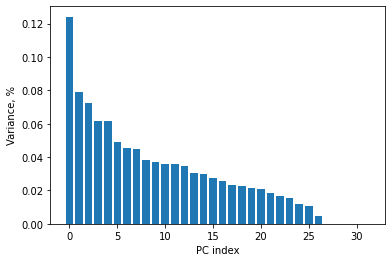

22 out of 32 principal components explain > 95% variance


In [32]:
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PC index')
plt.ylabel('Variance, %')
plt.show()

pc_num = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)
print(f"{pc_num} out of {len(pca.components_)} principal components explain > 95% variance")

### Define custom function to calculate correlation matrix between 22 most explanatory principal components and a set of genes chosen from 599 found differentially expressed ones

In [33]:
pc_num = 22
cols = [''.join(['PC', f'{i+1}']) for i in range(pc_num)]

train_test_scaled_pca_df = pd.DataFrame(
    train_test_scaled_pca[:,:pc_num],
    index=train_test.index,
    columns=cols
)

def calc_corr_for_gene_range(begin, end):
    train_test_scaled_df = pd.DataFrame(
        train_test_scaled[:,diff_exp_genes_inx[begin:end]],
        index=train_test.index,
        columns=diff_exp_genes[begin:end]
    )

    concatenated = pd.concat([train_test_scaled_pca_df, train_test_scaled_df], axis=1)
    
    corr_matrix = concatenated.corr().loc[cols, diff_exp_genes[begin:end]]
    
    return corr_matrix

In [34]:
sns.set(rc={'figure.figsize':(30,3)})

### Make sure most of differentially expressed genes actually correlates with chosen principal components

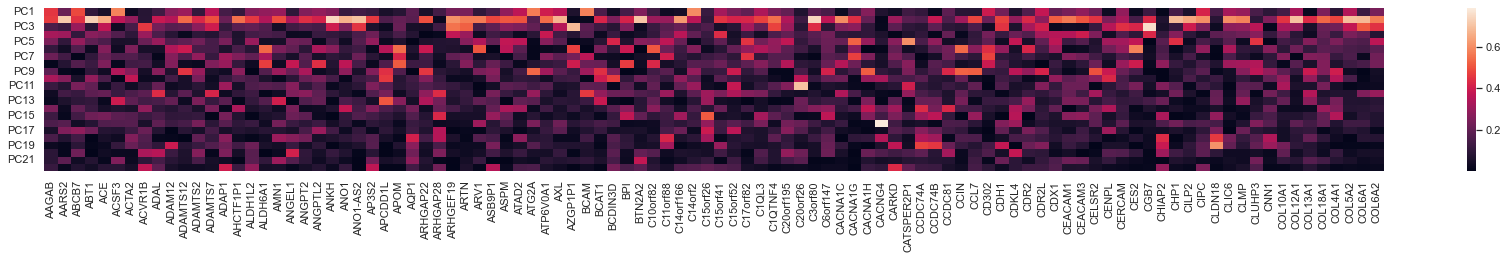

In [35]:
sns.heatmap(calc_corr_for_gene_range(0,100).abs());

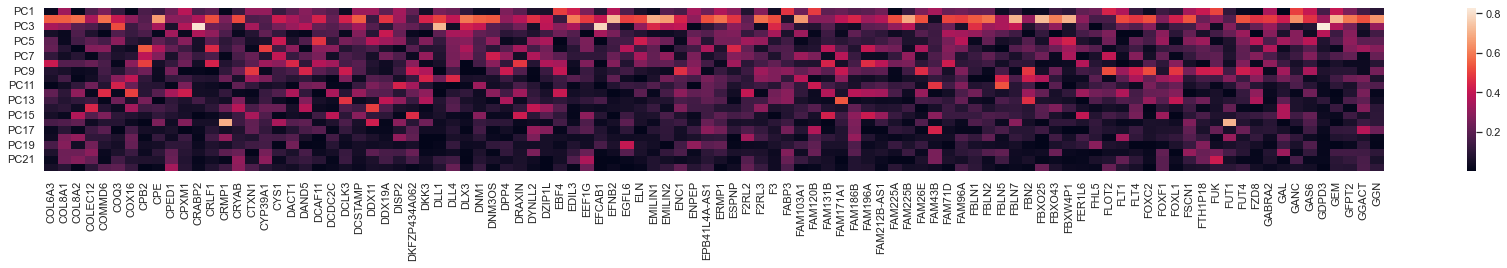

In [36]:
sns.heatmap(calc_corr_for_gene_range(100,200).abs());

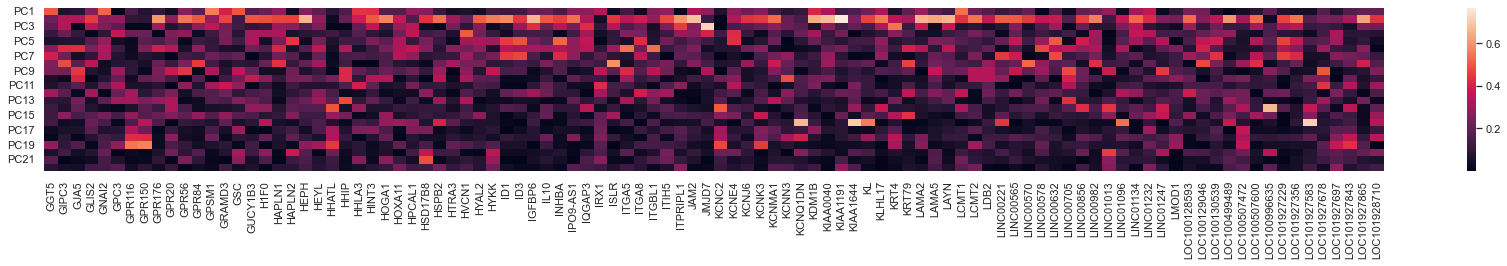

In [37]:
sns.heatmap(calc_corr_for_gene_range(200,300).abs());

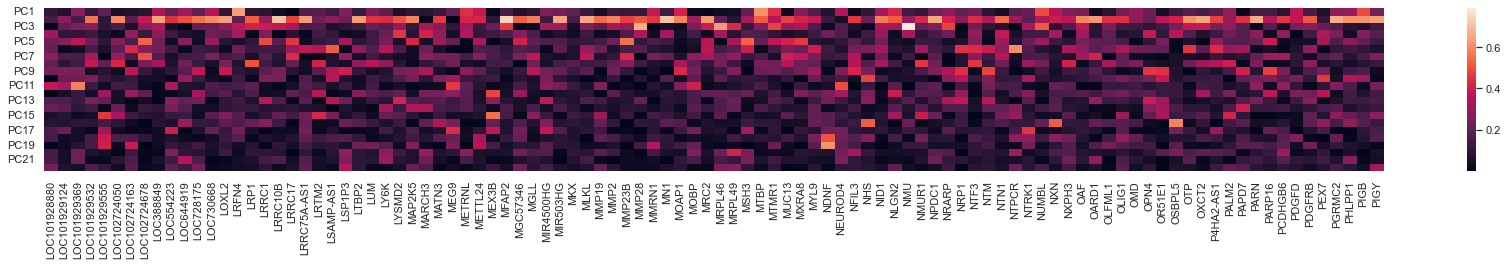

In [38]:
sns.heatmap(calc_corr_for_gene_range(300,400).abs());

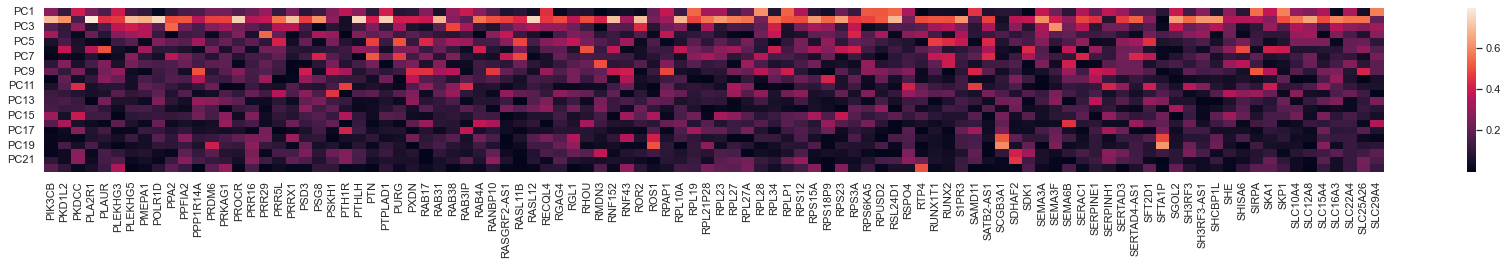

In [39]:
sns.heatmap(calc_corr_for_gene_range(400,500).abs());

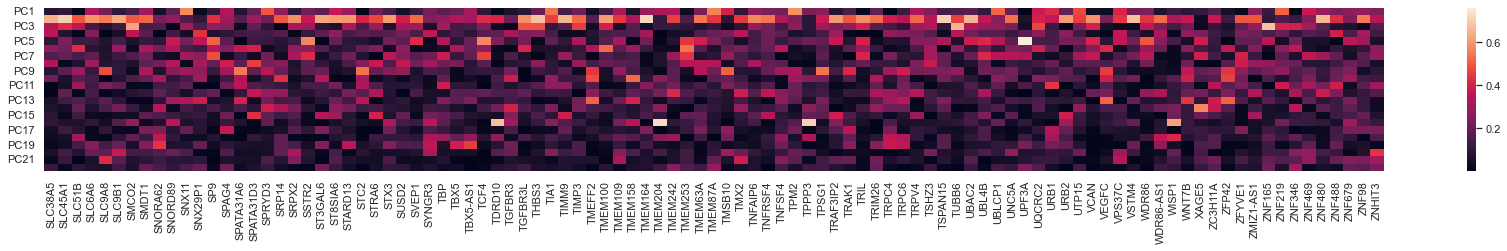

In [40]:
sns.heatmap(calc_corr_for_gene_range(500,600).abs());

___
## 3. Response Prediction
___

*To predict anti-PD1 therapy response relying on multidimentional features the folowing models were chosen:*
* Linear Models:
    * __SGD Classifier__
    * __LogReg Classifier__
* Boosting models:
    * __Bagging Classifier__
    * __AdaBoost Classifier__
    * __Random Forest Classifier__
    * __Gradient Boosting Classifier__
<!-- ensemble learning method, are chosen as far as they usually outperform other * -->

In [41]:
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier, RidgeClassifierCV
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier

### Separate train and test data containing chosen principal components

In [46]:
train_x = train_test_scaled_pca_df[train_test_scaled_pca_df.index.str.contains("train")]
test_x = train_test_scaled_pca_df[train_test_scaled_pca_df.index.str.contains("test")]

train_y = train_test_labels[train_test_labels.index.str.contains("train")]["Response"]
test_y = train_test_labels[train_test_labels.index.str.contains("test")]["Response"]

### Define a dictionary with initialized models

In [43]:
models = {
    "SGD Classifier": SGDClassifier(max_iter=1000, tol=1e-3),
    "LogReg Classifier": LogisticRegressionCV(cv=5, random_state=0),
    "Bagging Classifier": BaggingClassifier(n_estimators=10, random_state=0),
    "AdaBoost Classifier": AdaBoostClassifier(n_estimators=100, random_state=0),
    "Random Forest Classifier": RandomForestClassifier(max_depth=2, random_state=0),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

}

### Iterate over the preset models and display the prediction results

In [47]:
for name, model in models.items():
    print(name, end="\n")
    clf = model.fit(train_x, train_y)

    print("Prediction:\t", clf.predict(test_x))
    print("Ground truth:\t", test_y.values, end="\n\n")

SGD Classifier
Prediction:	 [1 1 0 0 0]
Ground truth:	 [1 1 0 0 0]

LogReg Classifier
Prediction:	 [1 1 0 0 0]
Ground truth:	 [1 1 0 0 0]

Bagging Classifier
Prediction:	 [1 1 0 0 0]
Ground truth:	 [1 1 0 0 0]

AdaBoost Classifier
Prediction:	 [1 1 0 0 0]
Ground truth:	 [1 1 0 0 0]

Random Forest Classifier
Prediction:	 [1 1 0 0 0]
Ground truth:	 [1 1 0 0 0]

Gradient Boosting Classifier
Prediction:	 [1 1 0 0 0]
Ground truth:	 [1 1 0 0 0]



*Surprisingly, all of chosen models provided the highest accuracy without any parameter tuning, which allows to reckon the data analysis steps being made were indeed rellevant. However, the test dataset is extremely small to provide strong validation so further investigations to the research are needed.*